In [1]:
# Import python libraries
import getpass
import json
import os
import pathlib
from glob import glob

# Library to work with tabular data
import pandas as pd

# Library to work with vector data
import geopandas as gpd

import earthpy.appeears as eaapp
import hvplot.pandas 
import hvplot.xarray
import rioxarray as rxr
import xarray as xr # uses numpy
import matplotlib.pyplot as plt

In [3]:
from shapely import wkt

In [2]:
den_hoods = pd.read_csv("https://data.colorado.gov/api/views/wiz6-8ftf/rows.csv?date=20240523&accessType=DOWNLOAD")
den_hoods

,the_geom,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES
0,MULTIPOLYGON (((-104.9981218111261 39.79102217...,11,Chaffee Park,NaN,NaN
1,MULTIPOLYGON (((-104.99817551932136 39.7825648...,62,Sunnyside,NaN,Focus Neighborhood
2,MULTIPOLYGON (((-104.9982032874223 39.76929730...,36,Highland,NaN,NaN
3,MULTIPOLYGON (((-104.96875416136173 39.7910397...,29,Globeville,NaN,Focus Neighborhood
4,MULTIPOLYGON (((-105.00948939245227 39.7539270...,39,Jefferson Park,NaN,Focus Neighborhood
...,...,...,...,...,...
73,MULTIPOLYGON (((-104.99169082474663 39.7522890...,63,Union Station,NaN,NaN
74,MULTIPOLYGON (((-104.97191569485533 39.7703010...,26,Five Points,NaN,Focus Neighborhood
75,MULTIPOLYGON (((-104.86603522693314 39.7984106...,60,Stapleton,NaN,NaN
76,MULTIPOLYGON (((-104.80989798184952 39.7728315...,45,Montbello,NaN,NaN


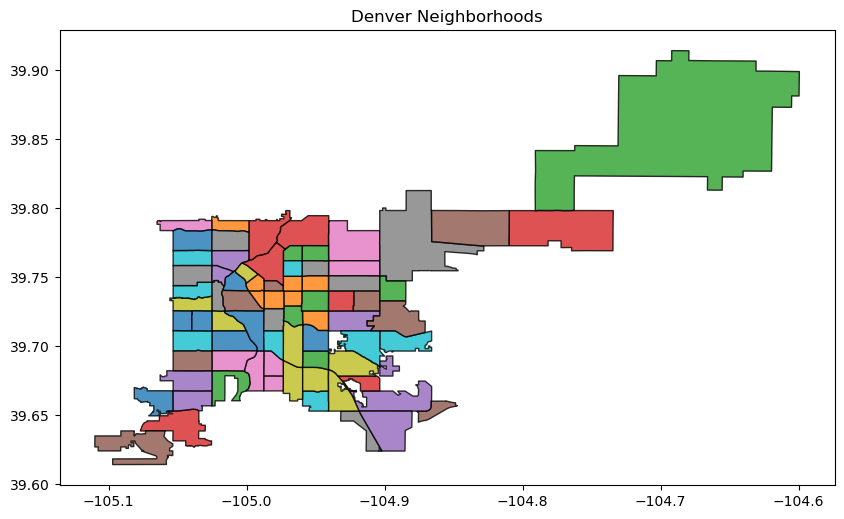

In [4]:
# Step 2: Convert the 'the_geom' column to a GeoSeries
# Assuming 'the_geom' contains WKT format geometries
den_hoods['geometry'] = den_hoods['the_geom'].apply(wkt.loads)

# Step 3: Create a GeoDataFrame
den_hoods_gdf = gpd.GeoDataFrame(den_hoods, geometry='geometry')

# Step 4: Plot the GeoDataFrame
fig, ax = plt.subplots(figsize=(10,10))
den_hoods_gdf.plot(ax=ax, edgecolor='black', alpha=0.8, column="NBHD_NAME")

plt.title("Denver Neighborhoods")
plt.show()

In [16]:
den_hoods_gdf.crs = "EPSG:4326"


In [17]:
print(den_hoods_gdf.crs)

EPSG:4326


In [18]:
# Select Cheesman Park
cheesman = den_hoods_gdf[den_hoods_gdf["NBHD_NAME"] == "Cheesman Park"]
cheesman 

,the_geom,NBHD_ID,NBHD_NAME,TYPOLOGY,NOTES,geometry
14,MULTIPOLYGON (((-104.9601924942363 39.72910940...,12,Cheesman Park,NaN,NaN,"MULTIPOLYGON (((-104.96019 39.72911, -104.9607..."


In [19]:
cheesman.explore()

In [12]:
data_dir = os.path.join(pathlib.Path.home(), 'cheesman-data')
# Make the data directory
os.makedirs(data_dir, exist_ok=True)

data_dir

'/home/jovyan/cheesman-data'

In [20]:
# Initialize AppeearsDownloader for MODIS NDVI data
ndvi_downloader = eaapp.AppeearsDownloader(
    download_key='cheesman-ndvi',
    ea_dir=data_dir,
    product='MOD13Q1.061',
    layer='_250m_16_days_NDVI',
    start_date="07-01",
    end_date="07-31",
    recurring=True,
    year_range=[2018, 2023],
    polygon=cheesman
)

ndvi_downloader.download_files(cache=True)

KeyboardInterrupt: 